In [1]:
import os
import numpy as np
import pandas as pd
import urllib
from sodapy import Socrata
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

sns.set_style("whitegrid", rc={"figure.figsize": (12, 8)})
sns.set_palette("colorblind")

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_FLDR = "eda"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", IMAGE_FLDR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
#open the locally saved csv
df = pd.read_csv('data/mgm.csv', index_col=0)

In [4]:
#create a function to clean up the data
def cleanup(dataframe=df):
    """This function converts columns to appropriate dtypes and resets the index."""
    
    cat_cols = pd.Index(['jobtype', 'licensefeetype', 'permitstatus', 'subdiv', 'usetype', 'zoning', 'permittypecode'])
    dataframe[cat_cols] = dataframe[cat_cols].apply(pd.Categorical)
    
    num_cols = pd.Index(['estimatedcost', 'totalfee'])
    dataframe[num_cols] = dataframe[num_cols].apply(pd.to_numeric, errors='coerce')
    
    dataframe['physical_location_zip'] = dataframe['physical_location_zip'].fillna(0).astype(np.int64)
    
    dataframe['issueddate'] = pd.DatetimeIndex(dataframe['issueddate'])

    dataframe['estimatedcost'] = dataframe['estimatedcost'].fillna(0) #replace null values with 0s
    dataframe['totalfee'] = dataframe['totalfee'].fillna(0) #replace null values with 0s
    
    dataframe['parcelno_clean'] = dataframe.parcelno.str.replace(" ", "").str.replace(".", "") #create a new columns with no spaces or periods in parcelno
    dataframe['parcelno_clean'] = dataframe['parcelno_clean'].fillna(0).astype(np.int64)
    
    drop_cols = ['contractors_location_address', 'issueddate',
       'contractors_location_city', 'contractors_location_state',
       'contractors_location_zip', 'contractorsaddress', 'contractorscity',
       'contractorsemail', 'contractorsphone',
       'contractorsstate', 'contractorszip', 'month', 'owndersaddress',
       'ownderszip', 'owners_location_address',
       'owners_location_city', 'owners_location_state', 'owners_location_zip',
       'ownerscity', 'ownersstate', 'permitstatus',
       'physicaladdress', 'physicalcity',
       'physicalstate', 'physicalzip', 'year']
    dataframe.drop(columns=drop_cols, inplace=True)
    
    dataframe = dataframe.reset_index()

cleanup()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17514 entries, 14316 to 17668
Data columns (total 24 columns):
contractors_location         11793 non-null object
contractorsname              17514 non-null object
description                  17514 non-null object
estimatedcost                17514 non-null float64
jobtype                      17514 non-null category
licensefeetype               16125 non-null category
owners_location              14012 non-null object
ownersname                   17489 non-null object
parcelno                     17445 non-null object
permitno                     17514 non-null object
permittypecode               17514 non-null category
permittypedescription        17514 non-null object
physical_location            16226 non-null object
latitude                     16226 non-null float64
longitude                    16226 non-null float64
physical_location_address    17514 non-null object
physical_location_city       17511 non-null object
physical_lo

In [6]:
#printing this list for project_proposal formatted for markdown
for col, typ in df.dtypes.items():
    print("|",col,"|",typ,"|")

| contractors_location | object |
| contractorsname | object |
| description | object |
| estimatedcost | float64 |
| jobtype | category |
| licensefeetype | category |
| owners_location | object |
| ownersname | object |
| parcelno | object |
| permitno | object |
| permittypecode | category |
| permittypedescription | object |
| physical_location | object |
| latitude | float64 |
| longitude | float64 |
| physical_location_address | object |
| physical_location_city | object |
| physical_location_state | object |
| physical_location_zip | int64 |
| subdiv | category |
| totalfee | float64 |
| usetype | category |
| zoning | category |
| parcelno_clean | int64 |


In [7]:
#print the column name and the first few items
for i in range(0,len(df.columns)):
    col = []
    col = df.columns[i]
    print(df.columns[i], list(df[col].value_counts().index)[:3])

contractors_location ["{'type': 'Point', 'coordinates': [-86.187505, 32.312643]}", "{'type': 'Point', 'coordinates': [-86.788261, 33.360016]}", "{'type': 'Point', 'coordinates': [-84.250983, 33.898235]}"]
contractorsname ['LOWDER NEW HOMES', 'CERT OF OCCUPANCY', 'WINDOWS USA']
description ['REPLACE WINDOWS TO EXISTING SINGLE FAMILY DWELLING. BEDROOM WINDOWS PER CODES. TO MEET ALL APPLICABLE CODES.', 'GENERAL REPAIRS TO EXISTING SINGLE FAMILY DWELLING TO REPLACE WINDOWS TO EXISTING SINGLE FAMILY DWELLING. BEDROOM WINDOWS PER CODES. MUST COMPLY WITH STATE ENERGY CODE. TO MEET ALL APPLICABLE CODES.', 'GENERAL REPAIRS TO REPLACE WINDOWS TO EXISTING DWELLING. BEDROOM WINDOWS PER CODES. TO MEET ALL APPLICABLE CODES.']
estimatedcost [0.0, 1000.0, 5000.0]
jobtype ['New', 'Existing', 'Alteration']
licensefeetype ['Building Fee', 'Lic Fee', 'Base Permit Fee']
owners_location ["{'type': 'Point', 'coordinates': [-86.187022, 32.312276]}", "{'type': 'Point', 'coordinates': [-86.788261, 33.360016]}",

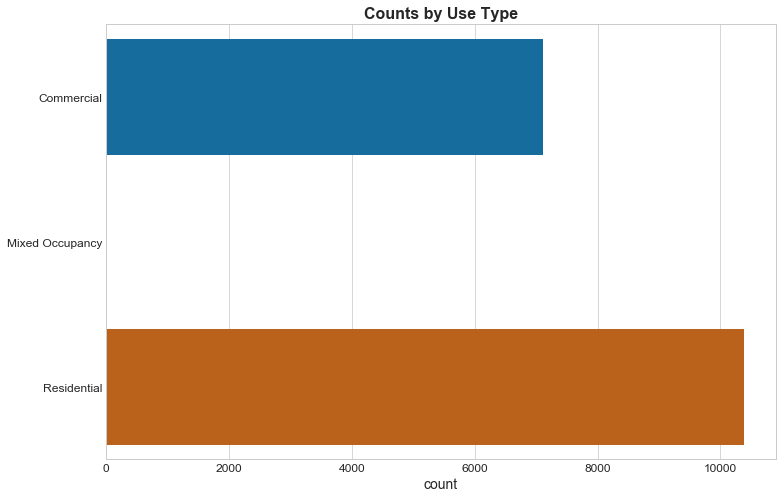

In [8]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='usetype')
g = ax.set_title('Counts by Use Type', fontdict={'fontsize': 16,'fontweight': 'bold'})
g = ax.set_ylabel("")

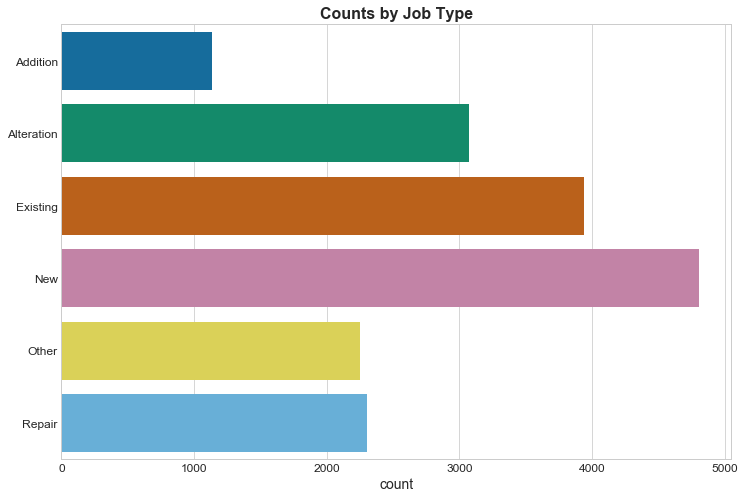

In [9]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='jobtype')
g = ax.set_title('Counts by Job Type', fontdict={'fontsize': 16,'fontweight': 'bold'})
g = ax.set_ylabel("")

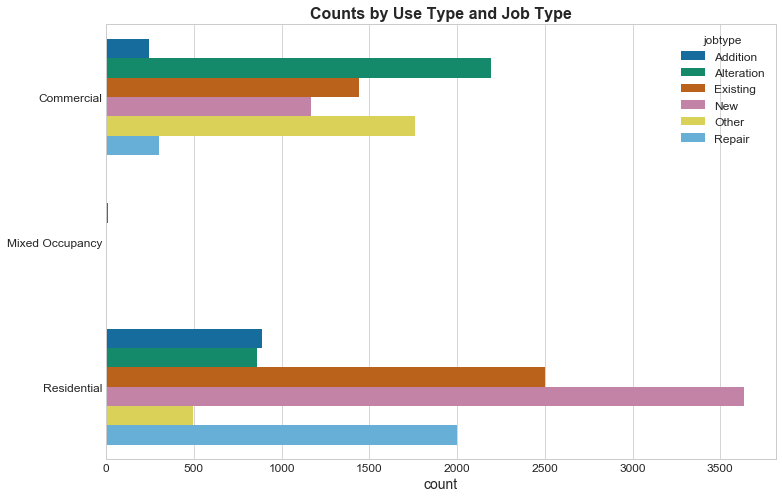

In [10]:
fig, ax = plt.subplots()
g = sns.countplot(data=df, y='usetype', hue='jobtype')
g = ax.set_title('Counts by Use Type and Job Type', fontdict={'fontsize': 16,'fontweight': 'bold'})
g = ax.set_ylabel("")

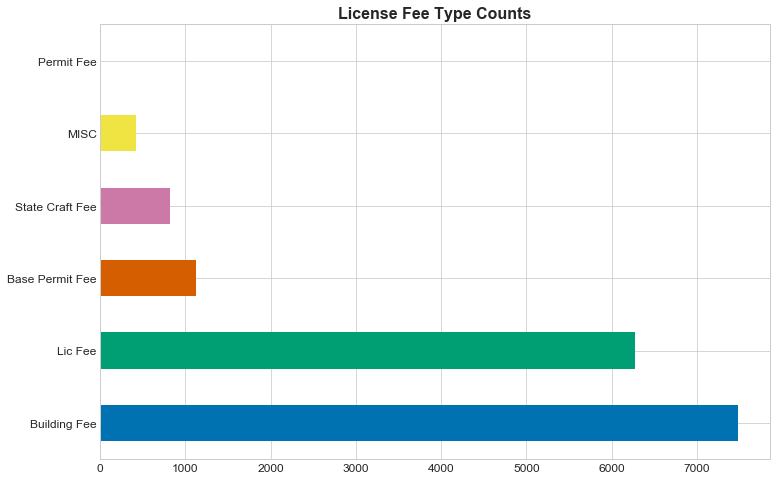

In [11]:
df.licensefeetype.value_counts().plot(kind='barh')
plt.title('License Fee Type Counts', fontdict={'fontsize': 16,'fontweight': 'bold'});

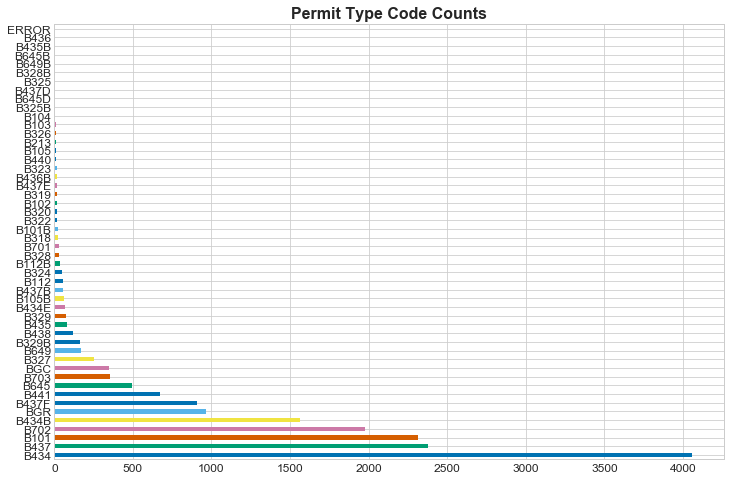

In [12]:
df.permittypecode.value_counts().plot(kind='barh')
plt.title('Permit Type Code Counts', fontdict={'fontsize': 16,'fontweight': 'bold'});

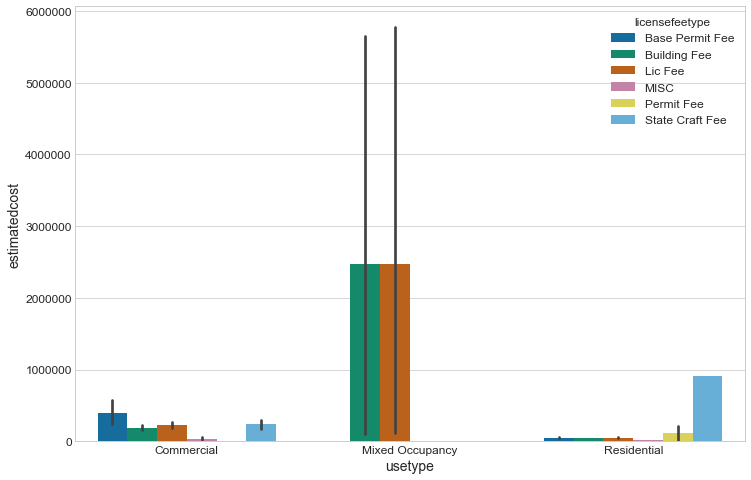

In [13]:
fig, ax = plt.subplots()
g = sns.barplot(data=df, x='usetype', y='estimatedcost', hue='licensefeetype')

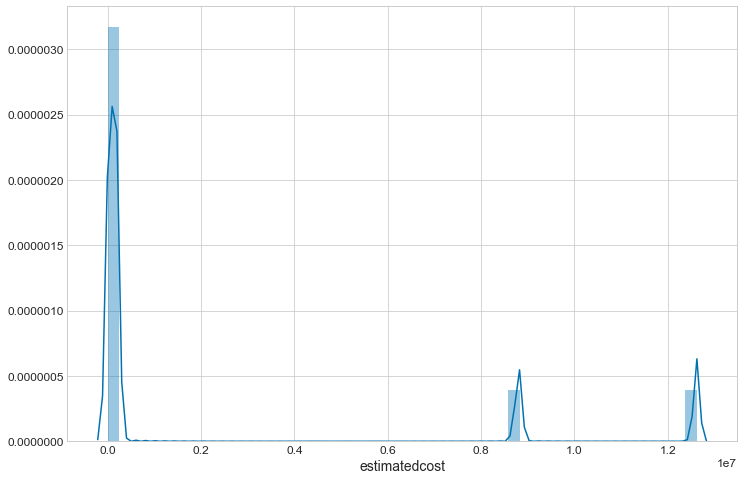

In [14]:
# df.estimatedcost[df.usetype=='Mixed Occupancy']
sns.distplot(df.estimatedcost[df.usetype=='Mixed Occupancy'])

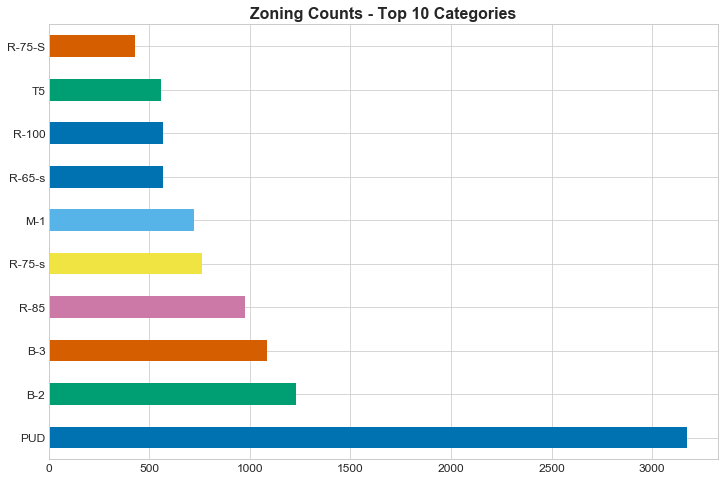

In [15]:
df.zoning.value_counts().head(10).plot(kind='barh')
plt.title('Zoning Counts - Top 10 Categories', fontdict={'fontsize': 16,'fontweight': 'bold'});

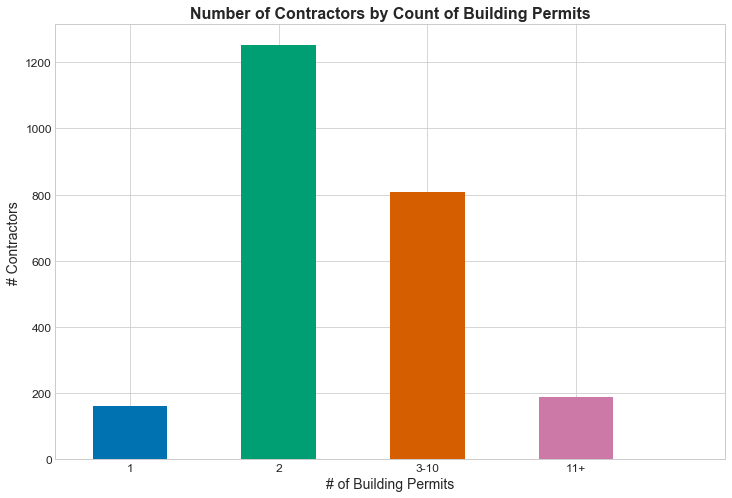

In [16]:
df.contractorsname.value_counts().sort_index().reset_index()['contractorsname'].value_counts(bins=[0,1,2,10,9999999999]).sort_index().plot(kind='bar')
plt.xticks((0,1,2,3,4), ['1','2','3-10','11+'], rotation='horizontal')
plt.title("Number of Contractors by Count of Building Permits", fontdict={'fontsize': 16,'fontweight': 'bold'})
plt.tick_params()
plt.ylabel("# Contractors")
plt.xlabel('# of Building Permits');

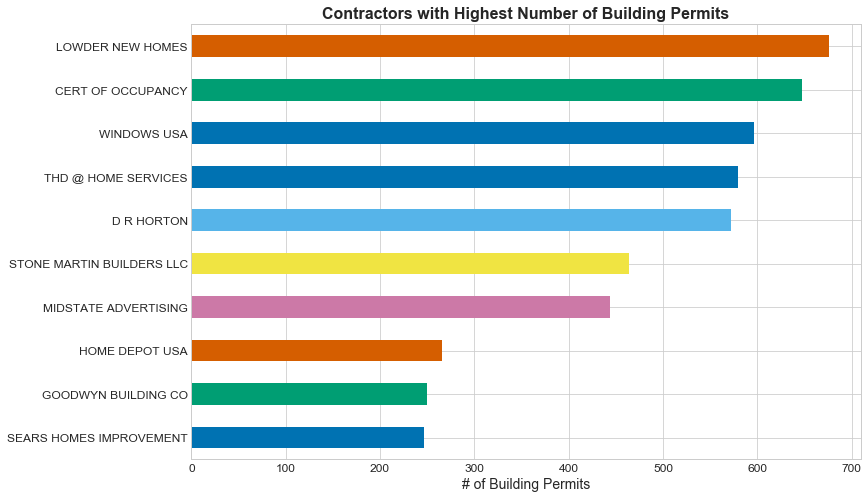

In [17]:
df.contractorsname.value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Contractors with Highest Number of Building Permits', fontdict={'fontsize': 16,'fontweight': 'bold'})
plt.xlabel('# of Building Permits');

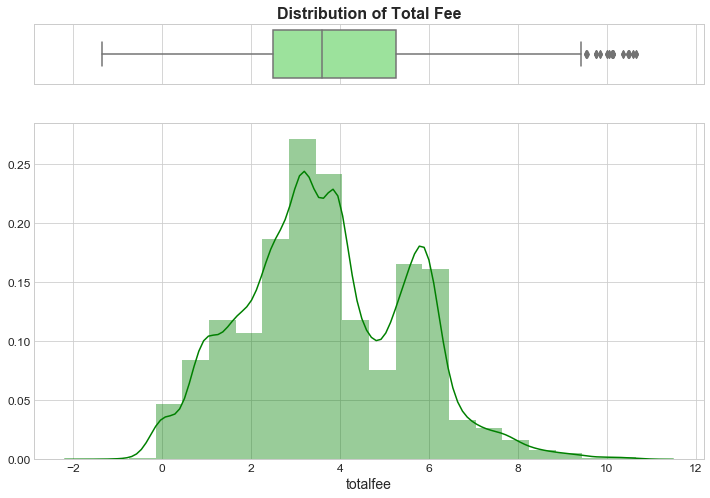

In [18]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(np.log(df.totalfee[df.totalfee != 0]), ax=ax_box, color='lightgreen')
sns.distplot(np.log(df.totalfee[df.totalfee != 0]), bins=20, ax=ax_hist, color='green')
ax_box.set(xlabel='', title='Distribution of Total Fee');

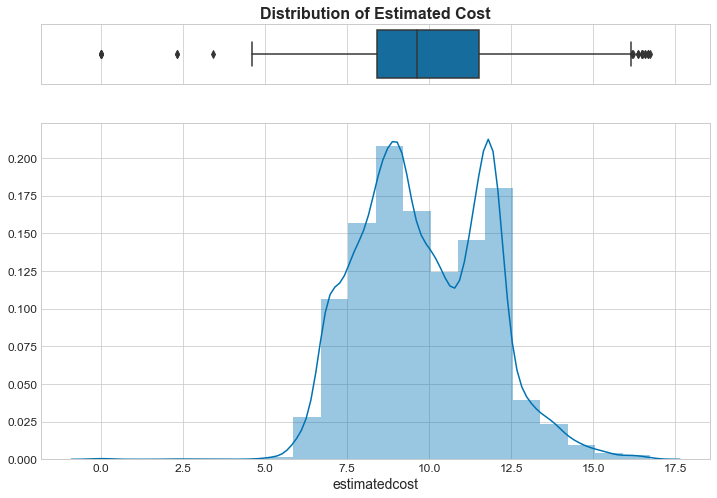

In [19]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
g = sns.boxplot(np.log(df.estimatedcost[df.estimatedcost != 0]), ax=ax_box) 
g = sns.distplot(np.log(df.estimatedcost[df.estimatedcost != 0]), bins=20, ax=ax_hist)
ax_box.set(xlabel='', title='Distribution of Estimated Cost');

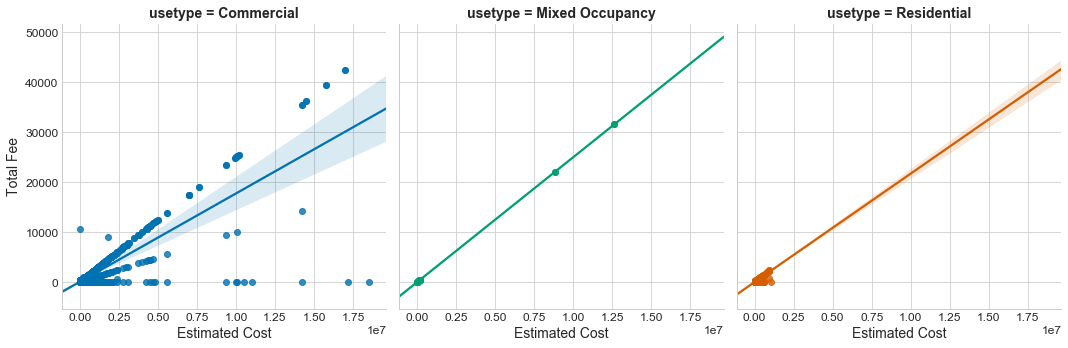

In [20]:
g = sns.lmplot(data=df, x='estimatedcost', y='totalfee', hue='usetype', col='usetype')
g = g.set_axis_labels("Estimated Cost", "Total Fee")

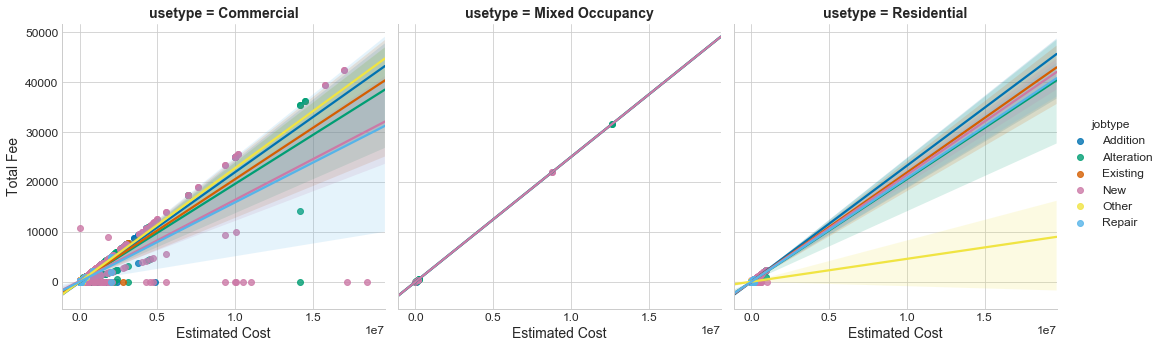

In [21]:
g = sns.lmplot(data=df, x='estimatedcost', y='totalfee', hue='jobtype', col='usetype')
g = g.set_axis_labels("Estimated Cost", "Total Fee")

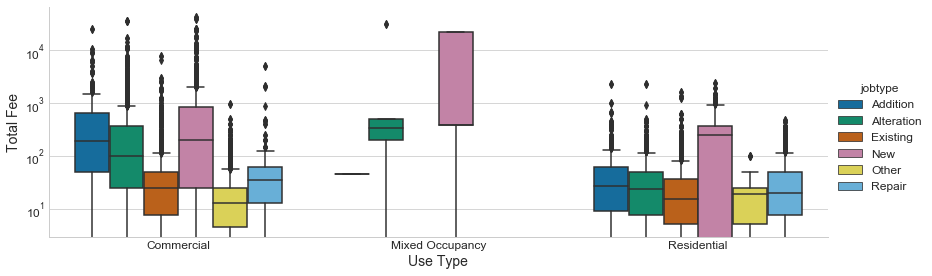

In [22]:
g = sns.factorplot(data=df, x='usetype', y='totalfee', hue='jobtype', kind='box', size=4, aspect=3)
g = g.set_axis_labels("Use Type", "Total Fee")
g = g.fig.get_axes()[0].set_yscale('log')

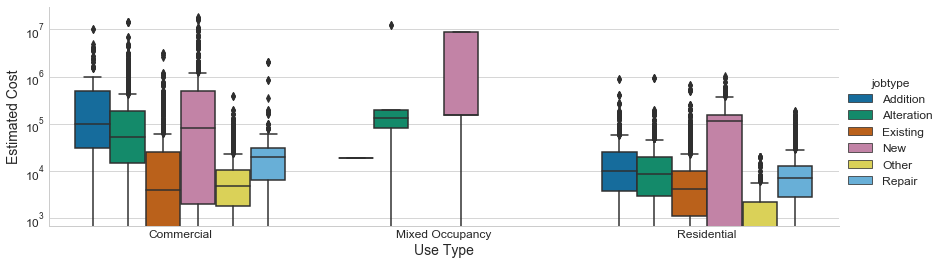

In [23]:
g= sns.factorplot(data=df, x='usetype', y='estimatedcost', hue='jobtype', kind='box', size=4, aspect=3)
g = g.set_axis_labels("Use Type", "Estimated Cost")
g.fig.get_axes()[0].set_yscale('log')

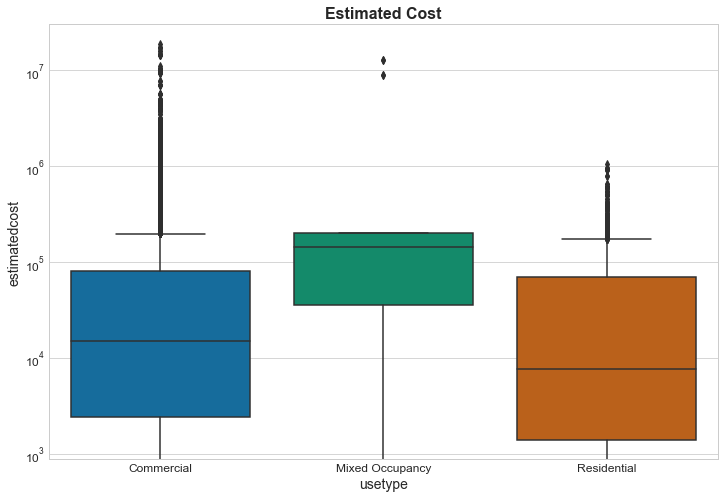

In [24]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='usetype', y='estimatedcost')
ax.set_yscale("log")
ax.set_title('Estimated Cost');

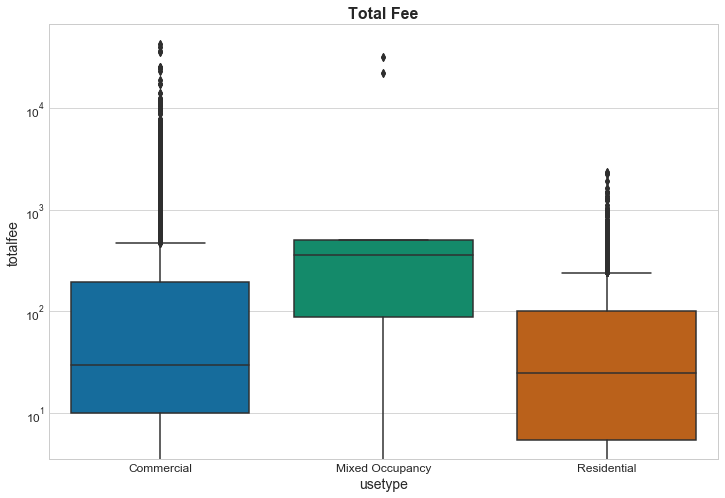

In [25]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='usetype', y='totalfee')
ax.set_yscale("log")
ax.set_title('Total Fee');

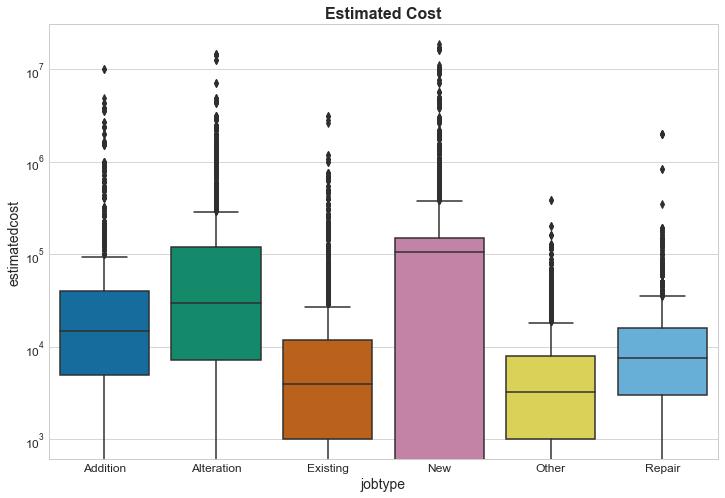

In [26]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='jobtype', y='estimatedcost')
ax.set_yscale("log")
ax.set_title('Estimated Cost');

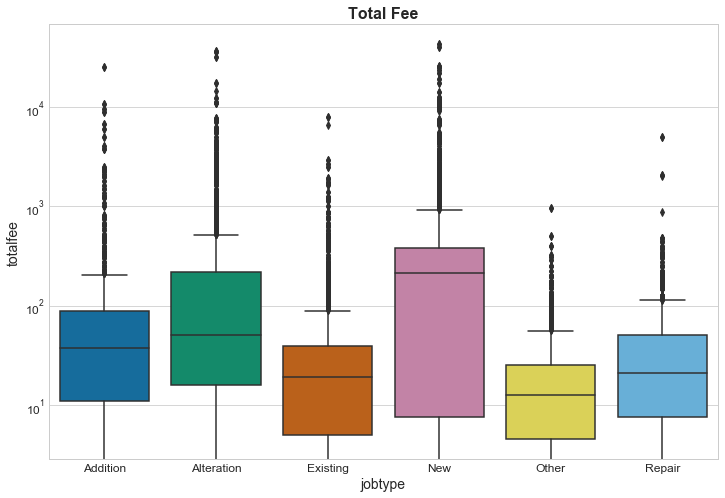

In [27]:
fig, ax= plt.subplots()
g = sns.boxplot(data=df, x='jobtype', y='totalfee')
ax.set_yscale("log")
ax.set_title('Total Fee');

In [28]:
#what does the contractors_location field look like
df.contractors_location[0]

"{'type': 'Point', 'coordinates': [-86.188228, 32.289181]}"

In [29]:
next(iter(list(df.contractors_location.value_counts().index) or []), None)

"{'type': 'Point', 'coordinates': [-86.187505, 32.312643]}"

In [30]:
#count how many permits by parcelno_clean to see if it's a good feature to use
df.groupby(by='parcelno_clean').usetype.value_counts().sort_values(ascending=False)

parcelno_clean    usetype    
1004181036002000  Commercial     72
1004181001001000  Commercial     72
905212000001006   Commercial     69
904201007007000   Commercial     55
0                 Residential    54
1003073301024000  Commercial     47
909291000005001   Commercial     46
909301000001014   Commercial     44
906232000003017   Commercial     43
903084000005000   Commercial     42
1005211002001004  Commercial     41
1002101007006000  Commercial     40
905211000001042   Commercial     37
1007351007001000  Commercial     34
906231000002012   Commercial     33
1003073303030000  Commercial     32
1406140000001000  Commercial     29
1005162012006000  Commercial     29
1002092013002000  Commercial     28
905221000001002   Commercial     28
1004181002001001  Commercial     28
905163000001040   Commercial     28
1006234007003000  Commercial     27
1006242001010000  Commercial     27
909294000001003   Commercial     27
905211000001000   Commercial     27
1009321001012000  Commercial     2

In [31]:
df[df.licensefeetype.isnull()]

contractors_location  \
13331  {'type': 'Point', 'coordinates': [-86.000477, ...   
11435  {'type': 'Point', 'coordinates': [-86.187022, ...   
11744  {'type': 'Point', 'coordinates': [-86.187022, ...   
12061  {'type': 'Point', 'coordinates': [-86.788261, ...   
12122  {'type': 'Point', 'coordinates': [-86.788261, ...   
12133  {'type': 'Point', 'coordinates': [-86.788261, ...   
12205  {'type': 'Point', 'coordinates': [-86.788261, ...   
12377  {'type': 'Point', 'coordinates': [-86.187022, ...   
12449  {'type': 'Point', 'coordinates': [-86.187022, ...   
12705  {'type': 'Point', 'coordinates': [-86.788261, ...   
13186  {'type': 'Point', 'coordinates': [-86.788261, ...   
13287  {'type': 'Point', 'coordinates': [-86.187022, ...   
11777  {'type': 'Point', 'coordinates': [-86.788261, ...   
11836  {'type': 'Point', 'coordinates': [-86.788261, ...   
12119  {'type': 'Point', 'coordinates': [-86.788261, ...   
12258  {'type': 'Point', 'coordinates': [-86.788261, ...   
12328  {'type': 'Point', 'coordinates': [-86.788261, ...   
12470  {'type': 'Point', 'coordinates': [-86.788261, ...   
12885  {'type': 'Point', 'coordinates': [-86.788261, ...   
11501  {'type': 'Point', 'coordinates': [-86.265378, ...   
12349  {'type': 'Point', 'coordinates': [-86.187022, ...   
12567  {'type': 'Point', 'coordinates': [-86.265378, ...   
10792  {'type': 'Point', 'coordinates': [-86.788261, ...   
11387  {'type': 'Point', 'coordinates': [-86.788261, ...   
5236   {'type': 'Point', 'coordinates': [-86.265378, ...   
10604  {'type': 'Point', 'coordinates': [-86.187022, ...   
11328  {'type': 'Point', 'coordinates': [-86.265378, ...   
5061   {'type': 'Point', 'coordinates': [-85.375869, ...   
10762  {'type': 'Point', 'coordinates': [-86.187022, ...   
10644  {'type': 'Point', 'coordinates': [-86.187022, ...   
...                                                  ...   
16749  {'type': 'Point', 'coordinates': [-86.268475, ...   
16801  {'type': 'Point', 'coordinates': [-86.396769, ...   
17071                                                NaN   
16950  {'type': 'Point', 'coordinates': [-86.187505, ...   
16962  {'type': 'Point', 'coordinates': [-86.187505, ...   
17050  {'type': 'Point', 'coordinates': [-86.187505, ...   
17058  {'type': 'Point', 'coordinates': [-86.268475, ...   
17137  {'type': 'Point', 'coordinates': [-86.187505, ...   
17167  {'type': 'Point', 'coordinates': [-86.187022, ...   
17018  {'type': 'Point', 'coordinates': [-85.375918, ...   
17026  {'type': 'Point', 'coordinates': [-86.187505, ...   
17028  {'type': 'Point', 'coordinates': [-85.375918, ...   
17048  {'type': 'Point', 'coordinates': [-85.375918, ...   
17049  {'type': 'Point', 'coordinates': [-85.375918, ...   
17074  {'type': 'Point', 'coordinates': [-85.375918, ...   
17083  {'type': 'Point', 'coordinates': [-85.375918, ...   
17092  {'type': 'Point', 'coordinates': [-85.375918, ...   
17120  {'type': 'Point', 'coordinates': [-85.375918, ...   
17133  {'type': 'Point', 'coordinates': [-85.375918, ...   
16980  {'type': 'Point', 'coordinates': [-86.268475, ...   
17198  {'type': 'Point', 'coordinates': [-86.268475, ...   
17233  {'type': 'Point', 'coordinates': [-86.187505, ...   
17249  {'type': 'Point', 'coordinates': [-86.268475, ...   
17305  {'type': 'Point', 'coordinates': [-86.187505, ...   
17311  {'type': 'Point', 'coordinates': [-86.187505, ...   
17298  {'type': 'Point', 'coordinates': [-87.904976, ...   
17313  {'type': 'Point', 'coordinates': [-85.375918, ...   
17322  {'type': 'Point', 'coordinates': [-85.375918, ...   
17429  {'type': 'Point', 'coordinates': [-86.176794, ...   
17631  {'type': 'Point', 'coordinates': [-86.187505, ...   

                        contractorsname  \
13331    MEYER & NAJEM CONSTRUCTION LLC   
11435                      MERCER HOMES   
11744                      MERCER HOMES   
12061                        D R HORTON   
12122                        D R HORTON   
12133                        D R HORTON   
12205         

In [32]:
null_cols = df.isnull().sum() 
null_cols[null_cols!=0].sort_values(ascending=False)

contractors_location       5721
owners_location            3502
subdiv                     1590
licensefeetype             1389
longitude                  1288
latitude                   1288
physical_location          1288
zoning                      908
parcelno                     69
physical_location_state      30
ownersname                   25
physical_location_city        3
dtype: int64

### Check for "residential" in description but usetype is equal to "Commercial" and vice versa.

In [33]:
pd.set_option('max_colwidth',400)
df[['usetype', 'description']][(df.description.str.contains('commercial')) & (df.usetype == 'Residential')]

usetype  \
12351  Residential   
13649  Residential   
1386   Residential   

                                                                                                                                                                                                                                                            description  
12351  alterations to existing commercial structure for the purpose of a 14x10 cover over front porch.  maintain proper exits during construction. framing inspeciton required. a copy of stamped plans must be on job site at all times. to meet all applicable codes.  
13649  alterations to existing commercial structure for the purpose of a 14x10 cover over front porch.  maintain proper exits during construction. framing inspeciton required. a copy of stamped plans must be on job site at all times. to meet all applicable codes.  
1386                                   DEMOLISH commercial STRUCTURE TO CLEAR LOT. BOND #321705, WATER WORKS 5416 AND HEALTH DEPT LETTER ON FILE.  THIS PERMIT IS GOOD FOR 30 DAYS.  FINAL INSPECTION WILL BE REQUIRED BY HOUSING CODES. TO MEET ALL APPLICABLE CODERS.

In [34]:
df[['usetype', 'description']][(df.description.str.contains('residential')) & (df.usetype == 'Commercial')]

usetype  \
11461  Commercial   
11829  Commercial   

                                                                                                                                                                                                                                                                                                                                                                                                           description  
11461  replace interior finish due to water damage.  level one alterations to lower level (replace intreior finish). Comply with IBC table 803. Space not to be used for residential occpancy (no approval) . any space where change of occupancy is desired must be first approved and permitted t hrough building and fire departments.  all applicable department inspections as required. to meet all applicabl...  
11829  replace interior finish due to water damage.  level one alterations to lower level (replace intreior finish). Comply with IBC table 803. Space not to be used for residential occpancy (no approval) . any space where change of occupancy is desired must be first approved and permitted t hrough building and fire departments.  all applicable department inspections as required. to meet all applicabl...

In [35]:
pd.reset_option('max_colwidth')

In [36]:
df.columns

Index(['contractors_location', 'contractorsname', 'description',
       'estimatedcost', 'jobtype', 'licensefeetype', 'owners_location',
       'ownersname', 'parcelno', 'permitno', 'permittypecode',
       'permittypedescription', 'physical_location', 'latitude', 'longitude',
       'physical_location_address', 'physical_location_city',
       'physical_location_state', 'physical_location_zip', 'subdiv',
       'totalfee', 'usetype', 'zoning', 'parcelno_clean'],
      dtype='object')

In [37]:
pd.DataFrame(df.groupby(['usetype', 'permittypedescription', 'description']).jobtype.value_counts())

jobtype
usetype     permittypedescription                     description                                        jobtype            
Commercial  Accessory Structure/Satellite Commercial  ERECT A 10' X 18' DETACHED STORAGE BUILDING ON ... New               4
            Accessory Structure/Satellite Residential ALTERATIONS TO EXISTING COMMERCIAL STRUCTURE TO... Existing          2
                                                      ERECT A 12' X 9' COMMERCIAL STORAGE BUILDING IN... New               2
                                                      ERECT A 20'X 30' OPEN STORAGE COMMERCIAL BUILDI... Addition          2
                                                      PERMITTING OF EXISTING COMMERCIAL STORAGE BUILD... Existing          2
                                                      REPLACE A 90''X48'' DIRECTIONAL SIGN.  FOOTING ... Existing          2
            Addition, Commercial                      ***********MASTER PERMIT*************  ALTERATI... Alteration        2
                                                      **NOT DOING ANY WORK**** INTERIOR DEMOLITION TO... Repair            2
                                                      711 SF ADDITION TO EXISTING COMMERCIAL STRUCTUR... Existing          2
                                                      9'8''x 19'4''ADDITION TO EXISTING COMMERCIAL ST... Existing          2
                                                      9'x11' addition to icon tower and exterior alte... Existing          2
                                                      ADDITION 26'10" X 36'2" TO THE STREET SIDE OF A... Addition          2
                                                      ADDITION 34'4' X 30'.5" ONE STORY  COMMERCIAL B... Addition          2
                                                      ADDITION 40'X30' TO EXISTING COMMERCIAL STRUCTU... Addition          1
                                                      ADDITION 80' X 65' ONE STORY METAL COMMERCIAL B... Addition          2
                                                      ADDITION AND ALTERATION TO EXISTION COMMERCIAL ... Existing          2
                                                      ADDITION AND ALTERATIONS TO EXISTING COMMERCIAL... Existing          2
                                                      ADDITION OF 18,935 SQ FT TO AN EXISTING COMMERC... Addition          4
                                                      ADDITION OF 32' X 44' CANOPY EXTENSION AND ALTE... Addition          3
                                                      ADDITION OF 350'X242' TO EXISTING COMMERCIAL BU... Addition          3
                                                      ADDITION OF A 214 SQ FT COMMERCIAL BUILDING TO ... New               5
                                                      ADDITION TO EXISTING COMMERCIAL STRUCTURE FOR I... Existing          2
                                                      ADDITION TO EXISTING COMMERCIAL STRUCTURE FOR T... Addition          2
                                                      ADDITIONAL FEES COLLECTED TO ERECT A 90' X 102'... Addition          3
                                                      ADDITIONS TO COVERD PATIO 31.5X14 AND DINING RO... Addition          2
                                                      ADDITON TO 264 SF AND RENOVATION TO EXISTING 65... Existing          2
                                                      ALERATION TO 100 SQ FT OF COMMERCIAL BUILDING T... Alteration        2
                                                      ALERATIONS TO EXISTING 11,559 SF OF COMMERCIAL ... Alteration        3
                                                      ALERATIONS TO EXISTING 2,000 SF OF COMMERCIAL B... Alteration        2
                                                      ALTERATION OF 7000 SQ. FT EXISTING COMMERCIAL F... Alteration        2
...                                                                                                                  

In [38]:
df.pivot_table(index = ['permittypedescription', 'licensefeetype'], columns = 'usetype', values = 'totalfee', aggfunc='count')

usetype                                                             Commercial  \
permittypedescription                              licensefeetype                
Accessory Structure/Satellite Commercial           Base Permit Fee         1.0   
                                                   Building Fee            1.0   
                                                   Lic Fee                 1.0   
                                                   MISC                    NaN   
                                                   Permit Fee              NaN   
                                                   State Craft Fee         1.0   
Accessory Structure/Satellite Residential          Base Permit Fee         NaN   
                                                   Building Fee            5.0   
                                                   Lic Fee                 5.0   
                                                   MISC                    NaN   
                                                   Permit Fee              NaN   
                                                   State Craft Fee         NaN   
Addition, Commercial                               Base Permit Fee        26.0   
                                                   Building Fee         1009.0   
                                                   Lic Fee               997.0   
                                                   MISC                   42.0   
                                                   Permit Fee              1.0   
                                                   State Craft Fee       231.0   
Additions, Residential                             Base Permit Fee         1.0   
                                                   Building Fee            9.0   
                                                   Lic Fee                 8.0   
                                                   MISC                    NaN   
                                                   Permit Fee              NaN   
                                                   State Craft Fee         1.0   
Alteration/Rennovation Commercial                  Base Permit Fee       208.0   
                                                   Building Fee          208.0   
                                                   Lic Fee               206.0   
                                                   MISC                   32.0   
                                                   Permit Fee              NaN   
                                                   State Craft Fee       207.0   
...                                                                        ...   
Townhouse                                          Base Permit Fee         NaN   
                                                   Building Fee            NaN   
                                                   Lic Fee                 NaN   
                                                   MISC                    NaN   
                                                   Permit Fee              NaN   
                                                   State Craft Fee         NaN   
Two Family Dwelling                                Base Permit Fee         NaN   
                                                   Building Fee            NaN   
                                                   Lic Fee                 NaN   
                                                   MISC                    NaN   
                                                   Permit Fee              NaN   
                                                   State Craft Fee         NaN   
WORKING PERMITS FOR MASTER B437                    Base Permit Fee         NaN   
                                                   Building Fee            NaN   
                                                   Lic Fee                 NaN   
                                                   MISC         

In [39]:
df.pivot_table(index = ['usetype', 'permittypedescription'], columns = ['licensefeetype'], values = 'totalfee', aggfunc='count')

licensefeetype                                                  Base Permit Fee  \
usetype     permittypedescription                                                 
Commercial  Accessory Structure/Satellite Commercial                        1.0   
            Accessory Structure/Satellite Residential                       NaN   
            Addition, Commercial                                           26.0   
            Additions, Residential                                          1.0   
            Alteration/Rennovation Commercial                             208.0   
            Alteration/Rennovation Residential                              4.0   
            Amusement and Recreation                                        4.0   
            Billboard Sign                                                  NaN   
            Certificate of Occupancy                                        3.0   
            Change of Occupancy                                             NaN   
            Churches & Religious                                            NaN   
            Demolition Residential                                          NaN   
            Demolition, Commercial                                          NaN   
            Demolition, Garage/Detached Commercial                          NaN   
            Demolition, Garage/Detached Residential                         NaN   
            Driveway Curb Cut Commercial                                    NaN   
            Driveway Curb Cut Residential                                   NaN   
            ERROR MADE - NO PERMIT                                          NaN   
            Fence/Retaining Walls Commercial                                NaN   
            Fence/Retaining Walls Residential                               NaN   
            Five or More Family Apartments - Master Permit                  NaN   
            GRADING PERMIT COMMERCIAL                                       NaN   
            GRADING PERMIT RESIDENTIAL                                      NaN   
            Garages, Carports, Etc.                                         NaN   
            Hospitals, Institutional, Etc.                                  2.0   
            Hotels, Motels, Etc.                                            1.0   
            Industrial                                                      2.0   
            Install Underground Cable                                       NaN   
            Master Permit Mixed Use                                         NaN   
            Modular/Manufactured Commercial/Single                          NaN   
...                                                                         ...   
Residential Five or More Family Apartments - Master Permit                  NaN   
            GRADING PERMIT COMMERCIAL                                       NaN   
            GRADING PERMIT RESIDENTIAL                                      NaN   
            Garages, Carports, Etc.                                        14.0   
            Hospitals, Institutional, Etc.                                  NaN   
            Hotels, Motels, Etc.                                            NaN   
            Industrial                                                      NaN   
            Install Underground Cable                                       NaN   
            Master Permit Mixed Use                                         NaN   
            Modular/Manufactured Commercial/Single                          NaN   
            Modular/Manufactured Residential/Double +                       NaN   
            Modular/Manufactured Residential/Single                         1.0   
            New Single Family Residence                                   222.0   
            Office, Banks & Professional                                    NaN   
            Other Non-Resid., Mobile Office, Etc.                           NaN   
            Pati

In [40]:
#Make a table of the Use Types and their percentages of the total 
table = df.pivot_table(values='totalfee', index='permittypedescription', columns='usetype', aggfunc='mean')
table
#table.sum(axis=1)
#table['%Commercial'] = ((table['Commercial'] / totals ) * 100)
# table['%Mixed'] = ((table['Mixed Occupancy'] / table['Total']) * 100)
# table['%Residential'] = ((table['Residential'] / table['Total']) * 100)
# table

usetype                                               Commercial  \
permittypedescription                                              
Accessory Structure/Satellite Commercial               18.500000   
Accessory Structure/Satellite Residential             106.000000   
Addition, Commercial                                  596.402915   
Additions, Residential                                133.000000   
Alteration/Rennovation Commercial                     323.009029   
Alteration/Rennovation Residential                    141.750000   
Amusement and Recreation                             1188.440000   
Billboard Sign                                        106.535714   
Certificate of Occupancy                               19.019910   
Change of Occupancy                                    69.416667   
Churches & Religious                                 6473.357143   
Demolition Residential                                 18.428571   
Demolition, Commercial                                 65.975758   
Demolition, Garage/Detached Commercial                       NaN   
Demolition, Garage/Detached Residential                24.000000   
Driveway Curb Cut Commercial                           25.000000   
Driveway Curb Cut Residential                           7.500000   
ERROR MADE - NO PERMIT                                  0.000000   
Fence/Retaining Walls Commercial                      251.066667   
Fence/Retaining Walls Residential                            NaN   
Five or More Family Apartments - Master Permit      13222.222222   
GRADING PERMIT COMMERCIAL                             204.790698   
GRADING PERMIT RESIDENTIAL                              0.000000   
Garages, Carports, Etc.                                      NaN   
Hospitals, Institutional, Etc.                       1855.857143   
Hotels, Motels, Etc.                                13963.200000   
Industrial                                           4658.500000   
Install Underground Cable                                    NaN   
Master Permit Mixed Use                                      NaN   
Modular/Manufactured Commercial/Single                 59.500000   
Modular/Manufactured Residential/Double +              50.000000   
Modular/Manufactured Residential/Single                      NaN   
New Single Family Residence                                  NaN   
Office, Banks & Professional                         3173.591837   
Other Non-Resid., Mobile Office, Etc.                 281.739130   
Patio Home                                                   NaN   
Practice Burn For Fire Department                            NaN   
Public Works & Utility                                687.500000   
Schools & Educational                                2222.500000   
Service Stations & Repair                            2084.600000   
Signs                                                  19.303862   
Stores & Merchantile, Warehouses (Mini)              2012.258964   
Structures Other Than Buildings                       141.906250   
Swimming Pools Residential                             72.727273   
Three-Four Family Apartment                          1166.666667   
Townhouse                                                    NaN   
Two Family Dwelling                                          NaN   
WORKING PERMITS FOR MASTER B437                         0.000000   
Working Permit Five or More Unit Apartment Buil...     44.213115   
Working Permit Mixed Use                             3812.500000   

usetype                                             Mixed Occupancy  \
permittypedescription                                                 
Accessory Structure/Satellite Commercial                        NaN   
Accessory Structure/Satellite Residential                      46.0   
Addition, Commercial                                        31545.0   
Additions, Residential                                          NaN   
Alteration/Rennovation Commercial    

In [41]:
table

usetype                                               Commercial  \
permittypedescription                                              
Accessory Structure/Satellite Commercial               18.500000   
Accessory Structure/Satellite Residential             106.000000   
Addition, Commercial                                  596.402915   
Additions, Residential                                133.000000   
Alteration/Rennovation Commercial                     323.009029   
Alteration/Rennovation Residential                    141.750000   
Amusement and Recreation                             1188.440000   
Billboard Sign                                        106.535714   
Certificate of Occupancy                               19.019910   
Change of Occupancy                                    69.416667   
Churches & Religious                                 6473.357143   
Demolition Residential                                 18.428571   
Demolition, Commercial                                 65.975758   
Demolition, Garage/Detached Commercial                       NaN   
Demolition, Garage/Detached Residential                24.000000   
Driveway Curb Cut Commercial                           25.000000   
Driveway Curb Cut Residential                           7.500000   
ERROR MADE - NO PERMIT                                  0.000000   
Fence/Retaining Walls Commercial                      251.066667   
Fence/Retaining Walls Residential                            NaN   
Five or More Family Apartments - Master Permit      13222.222222   
GRADING PERMIT COMMERCIAL                             204.790698   
GRADING PERMIT RESIDENTIAL                              0.000000   
Garages, Carports, Etc.                                      NaN   
Hospitals, Institutional, Etc.                       1855.857143   
Hotels, Motels, Etc.                                13963.200000   
Industrial                                           4658.500000   
Install Underground Cable                                    NaN   
Master Permit Mixed Use                                      NaN   
Modular/Manufactured Commercial/Single                 59.500000   
Modular/Manufactured Residential/Double +              50.000000   
Modular/Manufactured Residential/Single                      NaN   
New Single Family Residence                                  NaN   
Office, Banks & Professional                         3173.591837   
Other Non-Resid., Mobile Office, Etc.                 281.739130   
Patio Home                                                   NaN   
Practice Burn For Fire Department                            NaN   
Public Works & Utility                                687.500000   
Schools & Educational                                2222.500000   
Service Stations & Repair                            2084.600000   
Signs                                                  19.303862   
Stores & Merchantile, Warehouses (Mini)              2012.258964   
Structures Other Than Buildings                       141.906250   
Swimming Pools Residential                             72.727273   
Three-Four Family Apartment                          1166.666667   
Townhouse                                                    NaN   
Two Family Dwelling                                          NaN   
WORKING PERMITS FOR MASTER B437                         0.000000   
Working Permit Five or More Unit Apartment Buil...     44.213115   
Working Permit Mixed Use                             3812.500000   

usetype                                             Mixed Occupancy  \
permittypedescription                                                 
Accessory Structure/Satellite Commercial                        NaN   
Accessory Structure/Satellite Residential                      46.0   
Addition, Commercial                                        31545.0   
Additions, Residential                                          NaN   
Alteration/Rennovation Commercial    

In [42]:
df.pivot_table(values=['estimatedcost', 'totalfee'], index=['licensefeetype', 'jobtype'] , columns='usetype')

estimatedcost                                 \
usetype                       Commercial Mixed Occupancy    Residential   
licensefeetype  jobtype                                                   
Base Permit Fee Addition    4.840600e+05             NaN   30811.754386   
                Alteration  2.853391e+05             NaN   25686.400000   
                Existing    4.610495e+04             NaN   17008.748815   
                New         1.365214e+06             NaN  135742.315175   
                Other       3.575000e+03             NaN    3433.333333   
                Repair      7.782162e+04             NaN   12375.430189   
Building Fee    Addition    4.965083e+05    1.840000e+04   24344.887255   
                Alteration  2.698935e+05    2.211333e+06   21080.793451   
                Existing    4.128954e+04             NaN   11132.126615   
                New         4.895781e+05    4.476000e+06  127541.916928   
                Other       1.053257e+04             NaN    1373.257396   
                Repair      5.566174e+04             NaN   13998.485172   
Lic Fee         Addition    5.257567e+05    1.840000e+04   24604.833333   
                Alteration  2.693719e+05    2.211333e+06   21514.331620   
                Existing    6.279224e+04             NaN   13502.097689   
                New         7.416869e+05    4.476000e+06  141271.893885   
                Other       1.164681e+04             NaN    4256.235849   
                Repair      5.268863e+04             NaN   14031.965311   
MISC            Addition    4.385714e+04             NaN   15158.620690   
                Alteration  1.245706e+05             NaN   21994.444444   
                Existing    2.394743e+03             NaN   11143.422222   
                New         4.890182e+04             NaN   14339.130435   
                Other       5.556818e+03             NaN     900.000000   
                Repair      2.145733e+04             NaN   28922.857143   
Permit Fee      Addition             NaN             NaN            NaN   
                Alteration           NaN             NaN            NaN   
                Existing             NaN             NaN            NaN   
                New                  NaN             NaN  219000.000000   
                Other       4.400000e+03             NaN            NaN   
                Repair      1.000000e+03             NaN    5000.000000   
State Craft Fee Addition    4.784403e+05             NaN            NaN   
                Alteration  2.607573e+05             NaN  915800.000000   
                Existing    3.121861e+04             NaN            NaN   
                New         8.728454e+05             NaN            NaN   
                Other       1.038547e+04             NaN            NaN   
                Repair      6.397021e+04             NaN            NaN   

                               totalfee                              
usetype                      Commercial Mixed Occupancy Residential  
licensefeetype  jobtype                                              
Base Permit Fee Addition      50.000000             NaN   48.421053  
                Alteration    50.000000             NaN   49.090909  
                Existing      48.484848             NaN   49.123223  
                New           47.560976             NaN   47.665370  
                Other         12.500000             NaN   50.000000  
                Repair        47.297297             NaN   49.471698  
Building Fee    Addition    1245.659794       46.000000   61.362745  
                Alteration   674.967203     5528.333333   53.065491  
                Existing     112.082100             NaN   35.077950  
                New         1285.700560    11190.000000  327.118730  
                Other         29.695522             NaN   26.199704  
                Repair       139.335000             NaN   35.198114  
Lic Fee         Addition    1310.677778       46.00

In [43]:
df.drop(labels='physical_location_zip', axis=1)

contractors_location  \
14316  {'type': 'Point', 'coordinates': [-86.299463, ...   
14334  {'type': 'Point', 'coordinates': [-86.290842, ...   
14359  {'type': 'Point', 'coordinates': [-86.299463, ...   
14363  {'type': 'Point', 'coordinates': [-86.290842, ...   
14367  {'type': 'Point', 'coordinates': [-86.231162, ...   
14376  {'type': 'Point', 'coordinates': [-86.265378, ...   
14412  {'type': 'Point', 'coordinates': [-90.669696, ...   
14440  {'type': 'Point', 'coordinates': [-86.187022, ...   
14443  {'type': 'Point', 'coordinates': [-86.231162, ...   
14445  {'type': 'Point', 'coordinates': [-86.137567, ...   
14454  {'type': 'Point', 'coordinates': [-86.299651, ...   
14456  {'type': 'Point', 'coordinates': [-86.290842, ...   
14490  {'type': 'Point', 'coordinates': [-86.265378, ...   
14514  {'type': 'Point', 'coordinates': [-86.299651, ...   
14518  {'type': 'Point', 'coordinates': [-90.669696, ...   
14546  {'type': 'Point', 'coordinates': [-86.273271, ...   
14555  {'type': 'Point', 'coordinates': [-86.187022, ...   
14564  {'type': 'Point', 'coordinates': [-86.290842, ...   
14598  {'type': 'Point', 'coordinates': [-86.137567, ...   
14618  {'type': 'Point', 'coordinates': [-86.273271, ...   
14281  {'type': 'Point', 'coordinates': [-86.172575, ...   
14314  {'type': 'Point', 'coordinates': [-86.172575, ...   
14321  {'type': 'Point', 'coordinates': [-85.456806, ...   
14628  {'type': 'Point', 'coordinates': [-85.456806, ...   
14508  {'type': 'Point', 'coordinates': [-86.344108, ...   
14584  {'type': 'Point', 'coordinates': [-86.344108, ...   
14257                                                NaN   
14409                                                NaN   
14325                                                NaN   
14327                                                NaN   
...                                                  ...   
17502  {'type': 'Point', 'coordinates': [-84.568445, ...   
17516  {'type': 'Point', 'coordinates': [-86.187505, ...   
17527  {'type': 'Point', 'coordinates': [-86.742315, ...   
17533                                                NaN   
17535                                                NaN   
17538                                                NaN   
17540                                                NaN   
17541  {'type': 'Point', 'coordinates': [-84.568445, ...   
17543  {'type': 'Point', 'coordinates': [-86.742315, ...   
17544  {'type': 'Point', 'coordinates': [-86.187505, ...   
17547                                                NaN   
17549  {'type': 'Point', 'coordinates': [-86.187505, ...   
17560                                                NaN   
17576  {'type': 'Point', 'coordinates': [-86.202567, ...   
17578  {'type': 'Point', 'coordinates': [-86.202567, ...   
17596  {'type': 'Point', 'coordinates': [-86.202567, ...   
17598                                                NaN   
17600                                                NaN   
17604                                                NaN   
17616                                                NaN   
17621                                                NaN   
17625  {'type': 'Point', 'coordinates': [-86.202567, ...   
17627  {'type': 'Point', 'coordinates': [-86.202567, ...   
17631  {'type': 'Point', 'coordinates': [-86.187505, ...   
17644  {'type': 'Point', 'coordinates': [-84.568445, ...   
17645  {'type': 'Point', 'coordinates': [-84.568445, ...   
17648  {'type': 'Point', 'coordinates': [-84.568445, ...   
17651  {'type': 'Point', 'coordinates': [-86.202567, ...   
17665  {'type': 'Point', 'coordinates': [-86.742315, ...   
17668                                                NaN   

                     contractorsname  \
14316                 JOHN ASPINWALL   
14334           MIDSTATE ADVERTISING   
14359                 JOHN ASPINWALL   
14363           MIDSTATE ADVERTISING   
14367      MARSHALL DESIGN-BUILD LLC   
14376               ARONOV HOMES INC   
14412         CONLON CONSTRUCTION C

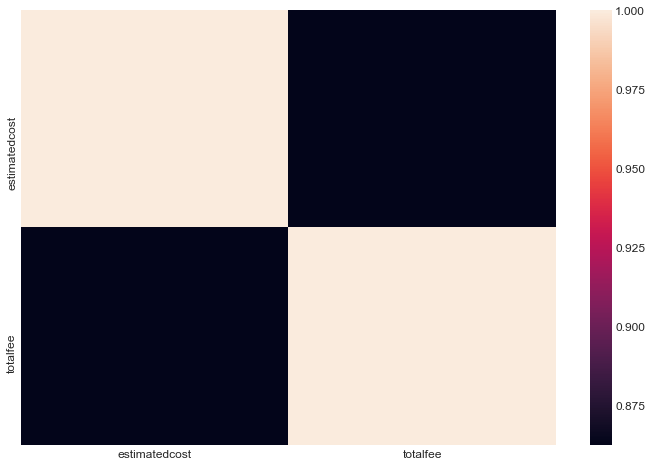

In [44]:
corr = df[['estimatedcost', 'totalfee']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

In [45]:
len(df)

17514

In [46]:
(df.estimatedcost > 0).sum()

14884

In [47]:
(df.totalfee > 0).sum()

16057

In [48]:
df[df.totalfee < 1]

contractors_location  \
13331  {'type': 'Point', 'coordinates': [-86.000477, ...   
12714                                                NaN   
12434                                                NaN   
11435  {'type': 'Point', 'coordinates': [-86.187022, ...   
11744  {'type': 'Point', 'coordinates': [-86.187022, ...   
12061  {'type': 'Point', 'coordinates': [-86.788261, ...   
12122  {'type': 'Point', 'coordinates': [-86.788261, ...   
12133  {'type': 'Point', 'coordinates': [-86.788261, ...   
12205  {'type': 'Point', 'coordinates': [-86.788261, ...   
12377  {'type': 'Point', 'coordinates': [-86.187022, ...   
12449  {'type': 'Point', 'coordinates': [-86.187022, ...   
12705  {'type': 'Point', 'coordinates': [-86.788261, ...   
13186  {'type': 'Point', 'coordinates': [-86.788261, ...   
13287  {'type': 'Point', 'coordinates': [-86.187022, ...   
11777  {'type': 'Point', 'coordinates': [-86.788261, ...   
11836  {'type': 'Point', 'coordinates': [-86.788261, ...   
12119  {'type': 'Point', 'coordinates': [-86.788261, ...   
12258  {'type': 'Point', 'coordinates': [-86.788261, ...   
12328  {'type': 'Point', 'coordinates': [-86.788261, ...   
12470  {'type': 'Point', 'coordinates': [-86.788261, ...   
12885  {'type': 'Point', 'coordinates': [-86.788261, ...   
11501  {'type': 'Point', 'coordinates': [-86.265378, ...   
12349  {'type': 'Point', 'coordinates': [-86.187022, ...   
12567  {'type': 'Point', 'coordinates': [-86.265378, ...   
10792  {'type': 'Point', 'coordinates': [-86.788261, ...   
11387  {'type': 'Point', 'coordinates': [-86.788261, ...   
5236   {'type': 'Point', 'coordinates': [-86.265378, ...   
10438  {'type': 'Point', 'coordinates': [-86.788261, ...   
10604  {'type': 'Point', 'coordinates': [-86.187022, ...   
11328  {'type': 'Point', 'coordinates': [-86.265378, ...   
...                                                  ...   
16749  {'type': 'Point', 'coordinates': [-86.268475, ...   
16801  {'type': 'Point', 'coordinates': [-86.396769, ...   
17071                                                NaN   
16950  {'type': 'Point', 'coordinates': [-86.187505, ...   
16962  {'type': 'Point', 'coordinates': [-86.187505, ...   
17050  {'type': 'Point', 'coordinates': [-86.187505, ...   
17058  {'type': 'Point', 'coordinates': [-86.268475, ...   
17137  {'type': 'Point', 'coordinates': [-86.187505, ...   
17167  {'type': 'Point', 'coordinates': [-86.187022, ...   
17018  {'type': 'Point', 'coordinates': [-85.375918, ...   
17026  {'type': 'Point', 'coordinates': [-86.187505, ...   
17028  {'type': 'Point', 'coordinates': [-85.375918, ...   
17048  {'type': 'Point', 'coordinates': [-85.375918, ...   
17049  {'type': 'Point', 'coordinates': [-85.375918, ...   
17074  {'type': 'Point', 'coordinates': [-85.375918, ...   
17083  {'type': 'Point', 'coordinates': [-85.375918, ...   
17092  {'type': 'Point', 'coordinates': [-85.375918, ...   
17120  {'type': 'Point', 'coordinates': [-85.375918, ...   
17133  {'type': 'Point', 'coordinates': [-85.375918, ...   
16980  {'type': 'Point', 'coordinates': [-86.268475, ...   
17198  {'type': 'Point', 'coordinates': [-86.268475, ...   
17233  {'type': 'Point', 'coordinates': [-86.187505, ...   
17249  {'type': 'Point', 'coordinates': [-86.268475, ...   
17305  {'type': 'Point', 'coordinates': [-86.187505, ...   
17311  {'type': 'Point', 'coordinates': [-86.187505, ...   
17298  {'type': 'Point', 'coordinates': [-87.904976, ...   
17313  {'type': 'Point', 'coordinates': [-85.375918, ...   
17322  {'type': 'Point', 'coordinates': [-85.375918, ...   
17429  {'type': 'Point', 'coordinates': [-86.176794, ...   
17631  {'type': 'Point', 'coordinates': [-86.187505, ...   

                        contractorsname  \
13331    MEYER & NAJEM CONSTRUCTION LLC   
12714          TRIPLE F LANDSCAPING INC   
12434              TAYLOR MICHELL GRANT   
11435                      MERCER HOMES   
11744                      MERCER HOMES   
12061                        D R HORTON   
12122         

In [49]:
df.groupby('usetype').estimatedcost.mean()

usetype
Commercial         2.170118e+05
Mixed Occupancy    2.223840e+06
Residential        4.421826e+04
Name: estimatedcost, dtype: float64

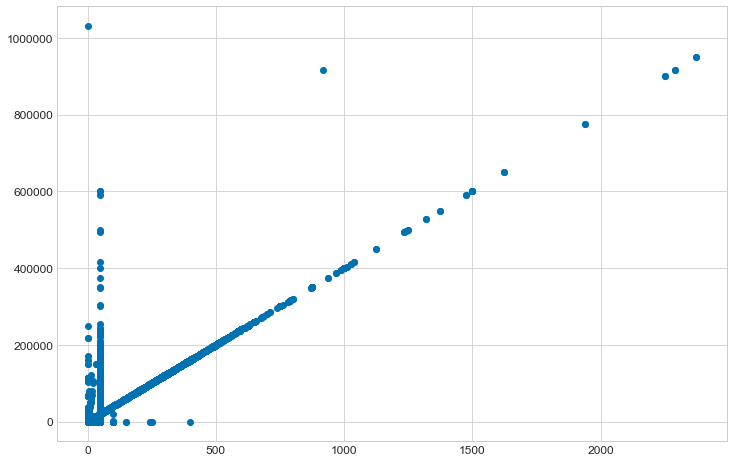

In [50]:
plt.scatter('totalfee', 'estimatedcost', data=df[df.usetype=='Residential'])

In [51]:
df[(df['totalfee'] == 0) & (df['estimatedcost'] == 0)]

contractors_location  \
13331  {'type': 'Point', 'coordinates': [-86.000477, ...   
11435  {'type': 'Point', 'coordinates': [-86.187022, ...   
11744  {'type': 'Point', 'coordinates': [-86.187022, ...   
12061  {'type': 'Point', 'coordinates': [-86.788261, ...   
12122  {'type': 'Point', 'coordinates': [-86.788261, ...   
12133  {'type': 'Point', 'coordinates': [-86.788261, ...   
12205  {'type': 'Point', 'coordinates': [-86.788261, ...   
12377  {'type': 'Point', 'coordinates': [-86.187022, ...   
12449  {'type': 'Point', 'coordinates': [-86.187022, ...   
12705  {'type': 'Point', 'coordinates': [-86.788261, ...   
13186  {'type': 'Point', 'coordinates': [-86.788261, ...   
13287  {'type': 'Point', 'coordinates': [-86.187022, ...   
11777  {'type': 'Point', 'coordinates': [-86.788261, ...   
11836  {'type': 'Point', 'coordinates': [-86.788261, ...   
12119  {'type': 'Point', 'coordinates': [-86.788261, ...   
12258  {'type': 'Point', 'coordinates': [-86.788261, ...   
12328  {'type': 'Point', 'coordinates': [-86.788261, ...   
12470  {'type': 'Point', 'coordinates': [-86.788261, ...   
12885  {'type': 'Point', 'coordinates': [-86.788261, ...   
11501  {'type': 'Point', 'coordinates': [-86.265378, ...   
12349  {'type': 'Point', 'coordinates': [-86.187022, ...   
12567  {'type': 'Point', 'coordinates': [-86.265378, ...   
10792  {'type': 'Point', 'coordinates': [-86.788261, ...   
11387  {'type': 'Point', 'coordinates': [-86.788261, ...   
5236   {'type': 'Point', 'coordinates': [-86.265378, ...   
10438  {'type': 'Point', 'coordinates': [-86.788261, ...   
10604  {'type': 'Point', 'coordinates': [-86.187022, ...   
11328  {'type': 'Point', 'coordinates': [-86.265378, ...   
11391  {'type': 'Point', 'coordinates': [-86.788261, ...   
5061   {'type': 'Point', 'coordinates': [-85.375869, ...   
...                                                  ...   
16932  {'type': 'Point', 'coordinates': [-86.176794, ...   
16749  {'type': 'Point', 'coordinates': [-86.268475, ...   
17071                                                NaN   
16950  {'type': 'Point', 'coordinates': [-86.187505, ...   
16962  {'type': 'Point', 'coordinates': [-86.187505, ...   
17050  {'type': 'Point', 'coordinates': [-86.187505, ...   
17058  {'type': 'Point', 'coordinates': [-86.268475, ...   
17137  {'type': 'Point', 'coordinates': [-86.187505, ...   
17167  {'type': 'Point', 'coordinates': [-86.187022, ...   
17018  {'type': 'Point', 'coordinates': [-85.375918, ...   
17026  {'type': 'Point', 'coordinates': [-86.187505, ...   
17028  {'type': 'Point', 'coordinates': [-85.375918, ...   
17048  {'type': 'Point', 'coordinates': [-85.375918, ...   
17049  {'type': 'Point', 'coordinates': [-85.375918, ...   
17074  {'type': 'Point', 'coordinates': [-85.375918, ...   
17083  {'type': 'Point', 'coordinates': [-85.375918, ...   
17092  {'type': 'Point', 'coordinates': [-85.375918, ...   
17120  {'type': 'Point', 'coordinates': [-85.375918, ...   
17133  {'type': 'Point', 'coordinates': [-85.375918, ...   
16980  {'type': 'Point', 'coordinates': [-86.268475, ...   
17198  {'type': 'Point', 'coordinates': [-86.268475, ...   
17233  {'type': 'Point', 'coordinates': [-86.187505, ...   
17249  {'type': 'Point', 'coordinates': [-86.268475, ...   
17305  {'type': 'Point', 'coordinates': [-86.187505, ...   
17311  {'type': 'Point', 'coordinates': [-86.187505, ...   
17298  {'type': 'Point', 'coordinates': [-87.904976, ...   
17313  {'type': 'Point', 'coordinates': [-85.375918, ...   
17322  {'type': 'Point', 'coordinates': [-85.375918, ...   
17429  {'type': 'Point', 'coordinates': [-86.176794, ...   
17631  {'type': 'Point', 'coordinates': [-86.187505, ...   

                        contractorsname  \
13331    MEYER & NAJEM CONSTRUCTION LLC   
11435                      MERCER HOMES   
11744                      MERCER HOMES   
12061                        D R HORTON   
12122                        D R HORTON   
12133                        D R HORTON   
12205         

In [52]:
df.groupby('usetype').estimatedcost.agg(['count', 'mean', 'min', 'max']).sort_values('mean')

count          mean  min         max
usetype                                              
Residential      10381  4.421826e+04  0.0   1030600.0
Commercial        7113  2.170118e+05  0.0  18500000.0
Mixed Occupancy     20  2.223840e+06  0.0  12618000.0

In [53]:
df.corr()

estimatedcost  latitude  longitude  \
estimatedcost               1.000000 -0.021917  -0.009868   
latitude                   -0.021917  1.000000  -0.032188   
longitude                  -0.009868 -0.032188   1.000000   
physical_location_zip       0.048118 -0.055958  -0.037814   
totalfee                    0.862470 -0.006893  -0.014217   
parcelno_clean              0.000410 -0.154400  -0.686521   

                       physical_location_zip  totalfee  parcelno_clean  
estimatedcost                       0.048118  0.862470        0.000410  
latitude                           -0.055958 -0.006893       -0.154400  
longitude                          -0.037814 -0.014217       -0.686521  
physical_location_zip               1.000000  0.045776        0.052388  
totalfee                            0.045776  1.000000       -0.000198  
parcelno_clean                      0.052388 -0.000198        1.000000

In [54]:
df[['permitno', 'permittypecode']]

permitno permittypecode
14316   B140003           B434
14334   B140006           B702
14359   B140003           B434
14363   B140007           B702
14367   B140009           B327
14376   B140004           B101
14412   B140002           B437
14440   B140005           B101
14443   B140009           B327
14445   B140010           B327
14454   B140008           B434
14456   B140006           B702
14490   B140004           B101
14514   B140008           B434
14518   B140002           B437
14546   B140001           B437
14555   B140005           B101
14564   B140007           B702
14598   B140010           B327
14618   B140001           B437
14281   B140011           B437
14314   B140011           B437
14321   B140012           B434
14628   B140012           B434
14508   B140013           B434
14584   B140013           B434
14257   B140014           B434
14409   B140014           B434
14325   B140016           B437
14327   B140016           B437
...         ...            ...
17502   B180967          B437F
17516   B180968           B101
17527   B180960           B702
17533   B180966          B434B
17535   B180966          B434B
17538   B180958           B438
17540   B180963           B441
17541   B180967          B437F
17543   B180960           B702
17544   B180968           B101
17547   B180958           B438
17549   B180968           B101
17560   B180964          B434B
17576  BG180959            BGC
17578   B180961           B322
17596   B180961           B322
17598   B180958           B438
17600   B180958           B438
17604   B180964          B434B
17616   B180962          B434B
17621   B180962          B434B
17625  BG180959            BGC
17627   B180961           B322
17631  BG180969            BGR
17644   B180967          B437F
17645   B180967          B437F
17648   B180967          B437F
17651   B180961           B322
17665   B180960           B702
17668   B180965           B441

[17514 rows x 2 columns]

## This is a working model using Logistic Regression

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
import sklearn.preprocessing as preproc
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel

In [56]:
#create the features and target variables
X = df['description']
y = df['usetype']
z = df['jobtype']

In [57]:
X_tr, X_te, y_tr, y_te, z_tr, z_te = train_test_split(X, y, z, test_size=0.20, random_state=42)

In [58]:
#create the bag-of-words representation and count its length
bow_transform = text.CountVectorizer(min_df=0, stop_words="english")
X_tr_bow = bow_transform.fit_transform(X_tr)
X_te_bow = bow_transform.transform(X_te)
len(bow_transform.vocabulary_)

8437

In [59]:
from wordcloud import WordCloud

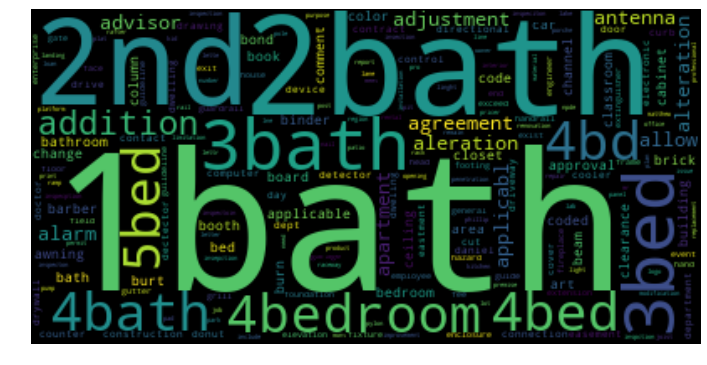

Saving figure wordcloud


In [60]:
# Create the wordcloud object
wordcloud = WordCloud().generate(" ".join(bow_transform.get_feature_names()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
save_fig("wordcloud")

In [61]:
#create tf-idf data using the bow matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

In [62]:
#l2-normalize the bow representations
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

### Logistic Classifier

In [63]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ### Helper function to train a logistic classifier and score on the test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print('Test score with', description, 'features:', s)
    return m

In [64]:
#model each representation and calculate the test scores
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.9900085640879246
Test score with l2-normalized features: 0.9774479017984584
Test score with tf-idf features: 0.9922923208678276


In [65]:
#specify the search grid
param_grid_ = {'C': [0.00001, 0.001, 0.1, 1.0, 10.0, 100.0]}

#tune the classifier for each representation
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_, return_train_score=True)
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_, return_train_score=True)
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_, return_train_score=True)

In [66]:
#tune classifier for bag-of-words representation
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [67]:
bow_search.best_score_

0.9907215759046464

In [68]:
bow_search.best_params_

{'C': 10.0}

In [69]:
#tune classifier for l2-normalized word vector
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
l2_search.best_score_

0.989008636071658

In [71]:
l2_search.best_params_

{'C': 100.0}

In [72]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
tfidf_search.best_score_

0.9912925558489758

In [74]:
tfidf_search.best_params_

{'C': 0.1}

In [75]:
tfidf_search.cv_results_

{'mean_fit_time': array([0.1454114 , 0.31874232, 0.72575917, 0.9591207 , 1.19385905,
        1.30165448]),
 'std_fit_time': array([0.00521462, 0.01756392, 0.04648861, 0.01425515, 0.09648629,
        0.07757664]),
 'mean_score_time': array([0.00400195, 0.00430222, 0.00410409, 0.00380249, 0.00410376,
        0.0046032 ]),
 'std_score_time': array([0.00089538, 0.00060048, 0.00058173, 0.00024495, 0.00111448,
        0.00049002]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.94612915, 0.98537281, 0.98929718, 0.99036746, 0.98894042,
        0.9864431 ]),
 'split1_test_score': array([0.9529076 , 0.98537281, 0.99072422, 0.9882269 , 0.98465929,
        0.98073493]),
 'split2_test_score': array([0.94898323, 0.98394577, 0.9892971

In [76]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score'],
                               'l2': l2_search.cv_results_['mean_test_score']})
search_results

bow        l2     tfidf
0  0.793805  0.594390  0.949754
1  0.971665  0.594390  0.985012
2  0.987510  0.789237  0.991293
3  0.988866  0.959817  0.990650
4  0.990722  0.981943  0.987938
5  0.989223  0.989009  0.985583

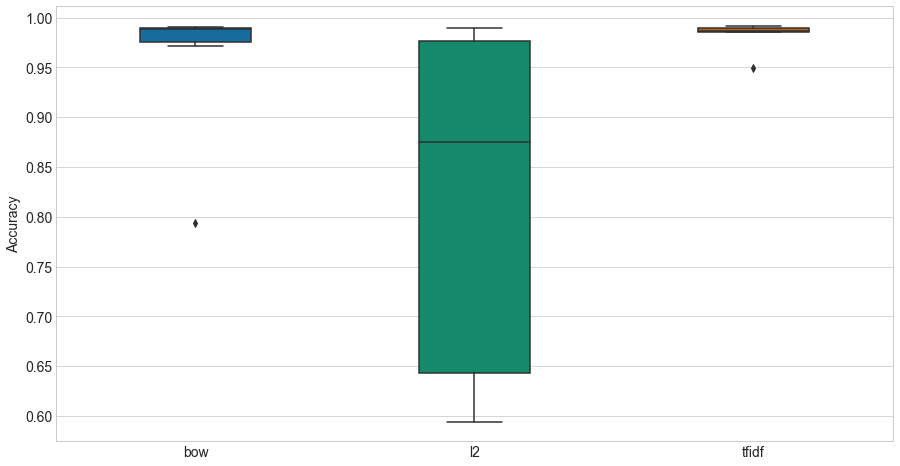

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14);

In [78]:
my1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
my2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
my3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.9931487296602912
Test score with l2-normalized features: 0.9908649728803882
Test score with tf-idf features: 0.9925777904653155


In [80]:
tfidf_search.best_params_['C']

0.1

In [81]:
mz1 = simple_logistic_classify(X_tr_bow, z_tr, X_te_bow, z_te, 'bow', 
                              _C=bow_search.best_params_['C'])
mz2 = simple_logistic_classify(X_tr_l2, z_tr, X_te_l2, z_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
mz3 = simple_logistic_classify(X_tr_tfidf, z_tr, X_te_tfidf, z_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.8992292320867827
Test score with l2-normalized features: 0.8615472452183842
Test score with tf-idf features: 0.8946617185269768


In [82]:
bow_search.cv_results_['mean_test_score']

array([0.79380487, 0.97166512, 0.98750981, 0.98886589, 0.99072158,
       0.98922275])

In [83]:
simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])

Test score with bow features: 0.9931487296602912


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
tfidf_search.best_params_['C']

0.1

In [85]:
simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', _C=tfidf_search.best_params_['C'])

Test score with tf-idf features: 0.9925777904653155


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## This is a working model using Random Forests

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
forest_clf = RandomForestClassifier(random_state=42)
param_grid_ = [
    {'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]},
]

# param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

bow_search = modsel.GridSearchCV(forest_clf, param_grid=param_grid_, cv=5, return_train_score=True)
l2_search = modsel.GridSearchCV(forest_clf, param_grid=param_grid_, cv=5, return_train_score=True)
tfidf_search = modsel.GridSearchCV(forest_clf, param_grid=param_grid_, cv=5, return_train_score=True)

In [88]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [89]:
bow_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [90]:
bow_search.best_score_

0.99214902576547

In [92]:
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [93]:
l2_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [94]:
l2_search.best_score_

0.99214902576547

In [95]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [113]:
tfidf_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [114]:
tfidf_search.best_score_

0.99214902576547

In [98]:
def rf_classify(X_tr, y_tr, X_test, y_test, description, param_grid):
    ### Helper function to train a random forest classifier and score on the test data
    m = forest_clf.fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print('Test score with', description, 'features:', s)
    return m

In [99]:
m1 = rf_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', param_grid=param_grid_)
m2 = rf_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', param_grid=param_grid_)
m3 = rf_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', param_grid=param_grid_)

Test score with bow features: 0.9922923208678276
Test score with l2-normalized features: 0.9908649728803882
Test score with tf-idf features: 0.9922923208678276


In [100]:
mz1 = rf_classify(X_tr_bow, z_tr, X_te_bow, z_te, 'bow', param_grid=param_grid_)
mz2 = rf_classify(X_tr_l2, z_tr, X_te_l2, z_te, 'l2-normalized', param_grid=param_grid_)
mz3 = rf_classify(X_tr_tfidf, z_tr, X_te_tfidf, z_te, 'tf-idf', param_grid=param_grid_)

Test score with bow features: 0.9286326006280331
Test score with l2-normalized features: 0.8695403939480445
Test score with tf-idf features: 0.9286326006280331


### Can we get a better result with a randomized search around the above best score?

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from time import time
from scipy.stats import randint as sp_randint

In [102]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"n_estimators": sp_randint(58, 68),
#              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
#              "min_samples_split": sp_randint(2, 11),
#              "min_samples_leaf": sp_randint(1, 11),
#              "bootstrap": [True, False],
 #             "criterion": ["gini", "entropy"]}
             }
# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(forest_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_tr_tfidf, y_tr)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 227.60 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.991 (std: 0.001)
Parameters: {'max_features': 8, 'n_estimators': 61}

Model with rank: 2
Mean validation score: 0.991 (std: 0.001)
Parameters: {'max_features': 7, 'n_estimators': 65}

Model with rank: 3
Mean validation score: 0.991 (std: 0.000)
Parameters: {'max_features': 10, 'n_estimators': 65}

Model with rank: 3
Mean validation score: 0.991 (std: 0.001)
Parameters: {'max_features': 10, 'n_estimators': 62}

Model with rank: 3
Mean validation score: 0.991 (std: 0.001)
Parameters: {'max_features': 2, 'n_estimators': 61}

